# Vector Quantization via Local Search and Integer Programming for Color Compression

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert_2^2}$

![Title image](./../data/img/20col.png)

## Introduction

Vector quantization refers to the problem of reducing the memory required to store data by transforming it into a representation which preserves the original information as well as possible. A classic application of this teqchnique is the color compression for *RGB images*. In this setting, one is given an image for which each pixel is described by three $8$-bit channels corresponding to red, green, and blue values ranging from $0$ to $255$. Clearly, this requires a total of 24 bits to represent at most $2^{24}$ possible color values. For most images, allocating this much memory is wasteful, as the number of colors actually present is much lower and not all colors are necessary to give a reasonable description of the image. For this reason, we would like to assign each pixel a smaller number of bits (e.g., 3, 8, etc.), thereby yielding an image with potentionally fewer colors that is *"as similar"* as possible to the input image.

We present two approaches for this problem and highlight their interplay. Firstly, we implement [Lloyd's algorithm for k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.). Unlike the classic algorithm and its [scikit-learn](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html) implementation, our algorithm leverages the discrete nature of the input, reducing the data to the set of unique color values present in the image. 

Secondly, we provide an integer programming (IP) formulation for the vector quantization problem. Due to the large number of variables, the naive formulation is not solvable with standard solvers. To overcome this issue, we leverage our local search algorithm to reduce the number of variables, making our program operational.

## Local search: k-means clustering

$\renewcommand{\norm}[1]{\left\lVert#1\right\rVert_2^2}$

Given $p$ vectors $x^i \in \mathbb{R}^n$, $i = 1, \dots, p$, and positive integer $k$, we wish to find $k$ centers $C = \{c^j \in \mathbb{R}^n: j = 1, \dots, k\}$ and assign each $x^i$ to some $c^j = c(i)$, where $c(i) = \underset{c^j \in C}{\text{argmin}}\norm{x^i - c^j}$. The objective is to minimize:

\begin{equation*}
    \sum_i^p \norm{x^i - c(i)}
\end{equation*}

The classical local search algorithm proceeds in the following way:

1. Sample $k$ centroids $c^1, \dots, c^n$ at random from $\{x^1, \dots, x^n\}$ and assign $x^i$ to $c(i)$ for every $i \in \{1, \dots, p\}$. Let $f := \sum_i^p \norm{x^i - c(i)}$;
2. Update $c^j = \frac{1}{d_j} \sum_{i \in Y_j}$, where $Y_j$ is the cluster with center $c^j$ and $d_j = |Y_j|$. Re-assign $x^i$ to $c(i)$ for every $i \in \{1, \dots, p\}$ and let $f' := \sum_i^p \norm{x^i - c(i)}$. If $f' = f$ STOP; otherwise set $f = f'$ and repeat step 2.

The most important implementation trick is noticing that that an image described by $l \times h$ pixels most likely has many pixels with the same value. As such, we can first extract the unique pixel values and their counts, then implement the algorithm described above using the unique values and adapting the cost function appropriately. At the end we discretize the result and output the image with the resulting centroid values for the corresponding pixel.

Number of unique colors: 20
(0) cost: 445953679.0
(1) cost: 290088963.0
(2) cost: 275473614.0
(3) cost: 275473614.0
Converged in 3 steps.


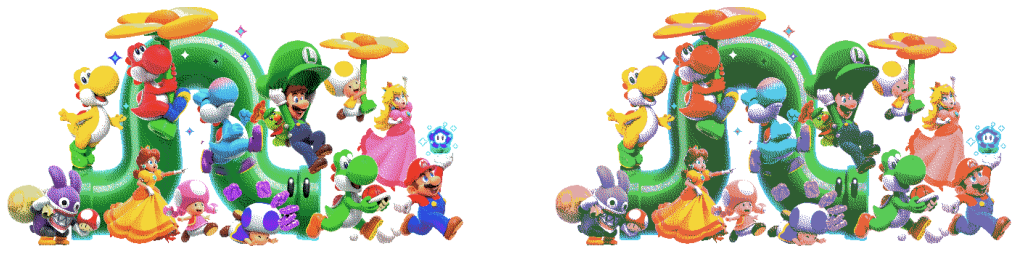

In [153]:
import os
import sys  
import matplotlib.pyplot as plt

cdir_path = os.getcwd()
sys.path.insert(1, cdir_path+"/../src")

import recolor # k-means algorithm implementation
import utils # image object handling

img = utils.ImgData("20col.png", "20colout.png")
kmeans1 = recolor.Lloyd(img, 8, seed=0)
kmeans1.run(save_img=False, verbose=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].imshow(img.input_pil)
axes[0].axis('off')  
axes[1].imshow(img.output_pil)
axes[1].axis('off')  
plt.show()

Notice that the output depends on the random initialization. Here is the same code with a different random seed:

Number of unique colors: 20
(0) cost: 2079850960.0
(1) cost: 411528038.0
(2) cost: 327173032.0
(3) cost: 327173032.0
Converged in 3 steps.


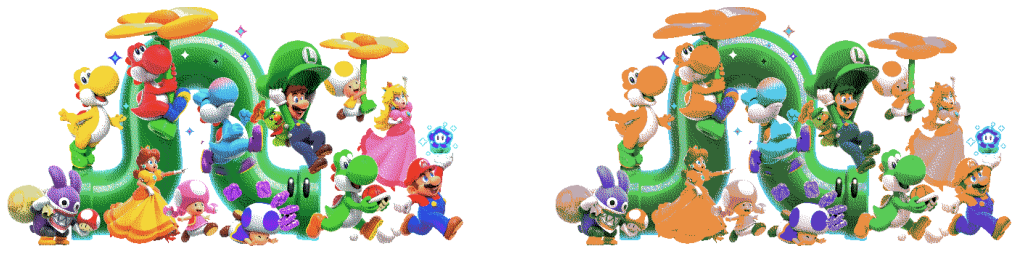

In [154]:
kmeans2 = recolor.Lloyd(img, 8, seed=23)
kmeans2.run(save_img=False, verbose=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 20))
axes[0].imshow(img.input_pil)
axes[0].axis('off')  
axes[1].imshow(img.output_pil)
axes[1].axis('off')  
plt.show()

The first output seems to capture the original colors much better. In fact, we can quanitify how similar/dissimilar the output images are w.r.t. to the input by looking at the value of the objective function:

In [155]:
print(f"k-means with seed 0 yielded a cost of {kmeans1.get_cost()}")
print(f"k-means with seed 23 yielded a cost of {kmeans2.get_cost()}")

k-means with seed 0 yielded a cost of 275473614.0
k-means with seed 23 yielded a cost of 327173032.0


This is a demonstration of the fact that local search algorithm converge to *local minima*, but may be far away from the *global minimum*. This begs the question: can we find the global optimal solution to our problem? We will achieve this goal with *integer programming*.

## Integer programming formulation

To specify a linear integer program, we need to define our data, variables, and model. 

### Data

$\renewcommand{\norm}[1]{\left\lVert#1\right\rVert_2^2}$

Let $\mathcal{I} := \{1, \dots, p\}$. Each data point $x^i$, with $i \in \mathcal{I}$, belongs to $R^3$ (i.e. $n = 3$), with each component representing a value for one of the three *RGB channels*. We observe that each center $c^j$ must also correspond to an *RGB value*, i.e. a tuple of 3 bytes representing the value of the red, green, and blue channels. While in the general problem formulation $c^j$ can be any element of $\mathbb{R}^n$, our restricted setting allows us to identify the set of possible centers with the set $\mathcal{J} := \{j : j = 0, 1, \dots, 2^{24}-1\}$. Indeed, given an integer $j \in \mathcal{J}$ in binary representation, the number represented by each byte corresponds to the red, green, and blue values. Therefore, given the binary representation $(j)_2 = (b_{27} \dots b_{20})(b_{17} \dots b_{10})(b_{07} \dots b_{00})$, we define $c_j := ((b_{27} \dots b_{20})_{10}, (b_{17} \dots b_{10})_{10}, (b_{07} \dots b_{00})_{10}) \in \mathbb{R}^3$ for all $j \in \mathcal{J}$. 

Let us then introduce the matrix $D \in \mathbb{R}^{n \times m}$, where $m := |\mathcal{J}| = 2^{24}$. For every $i \in \mathcal{I}$ and for every $j \in \mathcal{J}$, we define $(D)_{i,j} := d_{ij} = \norm{x^i - c^j}$, i.e. the distance from point $x^i$ to center $c^j$.

### Variables

We introduce binary variables $y_j$, with $j \in \mathcal{J}$, such that $y_j = 1$ if and only if $c^j$ is one of the $k$ selected centers. Moreover, we introduce binary variables $z_{ij}$, with $i \in \mathcal{I}$ and $j \in \mathcal{J}$, such that $z_{ij} = 1$ if and only if $x^i$ is assigned to the cluster formed around the center $c^j$. This yields a total number of variables equal to $m(p + 1) = 2^{24}(p + 1)$.

### Model

Using the data and the variables introduced in the previous sections, we are ready to formulate our problem as an Integer Program (IP) in the following way:

$$
\begin{array}{ll}
\text{minimize}  & \displaystyle\sum\limits_{j\in\mathcal{J}} \displaystyle\sum\limits_{i\in\mathcal{I}} d_{ij}&z_{ij} &\\
\text{subject to}& \displaystyle\sum\limits_{j \in \mathcal{J}}   &y_{j} \leq k,  &\\
& \displaystyle\sum\limits_{j \in \mathcal{J}}   &z_{ij} =1,  &i\in\mathcal{I}\\
&                & z_{ij} \le y_j &i \in \mathcal{I}, j \in \mathcal{J} \\
                 &
                 &y_{j} \in \{0,1\}, &j\in\mathcal{J} \\
                 &
                 &z_{ij} \in \{0,1\}, &i\in\mathcal{I}, j\in\mathcal{J} \\
\end{array}
$$
The objective function represents the total dissimilarity given the distance matrix and the assignment of each data point to a center. Note that since the distance matrix was pre-computed, it is a parameter of the model, meaning the linear structure is preserved. The first constraint ensures that the total number of centers is at most $k$. The second constraint imposes that each point $x^i$ is assigned to exactly one center $c^j$. The third constraint reflects the idea that if $x^i$ is assigned to $c^j$, then the latter must be among the selected centers. Finally, all our variables are binary.

### Comments

While relatively straightforward, this formulation is not operational due to its large number of variables. The key point lies in the exponentially large number of centers. Is there a way to eliminate centers that yield very large dissimilarity scores? To do this, we can leverage our local search algorithm!

## Local search meets integer programming

We will employ the following $2$-step strategy: 

1. Run k-means with several random initialization and store the best (i.e., lowest) value of the objective function;
2. Generate all possible clusters, find their center, and compute the cost associated to this cluster. If it is greater than the threshold found with our local search approach, then it cannot be among the centers selected in the optimal solution.

A key point has to do with structure of out input data. Since many pixels have the same value, it is enough to look at unqiue color values. If a data point (i.e., color) is assigned to a center, then all the other data points (i.e., pixels) that have the same value will be assigned to the same cluster. 

In [156]:
import simplifier

thresh_gen = simplifier.Threshold_Generator(img, 8)
thresh_gen.run()

simplifier = simplifier.Simplifier(img, 8, thresh_gen.get_threshold())   
simplifier.run()

seed 0 coverged in 3 steps.
seed 1 coverged in 4 steps.
seed 2 coverged in 4 steps.
seed 3 coverged in 3 steps.
seed 4 coverged in 3 steps.
seed 5 coverged in 3 steps.
seed 6 coverged in 3 steps.
seed 7 coverged in 3 steps.
seed 8 coverged in 3 steps.
seed 9 coverged in 3 steps.
seed 10 coverged in 3 steps.
seed 11 coverged in 4 steps.
seed 12 coverged in 2 steps.
seed 13 coverged in 5 steps.
seed 14 coverged in 3 steps.
seed 15 coverged in 3 steps.
seed 16 coverged in 3 steps.
seed 17 coverged in 3 steps.
seed 18 coverged in 3 steps.
seed 19 coverged in 3 steps.
seed 20 coverged in 5 steps.
seed 21 coverged in 3 steps.
seed 22 coverged in 5 steps.
seed 23 coverged in 3 steps.
seed 24 coverged in 3 steps.
seed 25 coverged in 4 steps.
seed 26 coverged in 4 steps.
seed 27 coverged in 2 steps.
seed 28 coverged in 3 steps.
seed 29 coverged in 3 steps.
seed 30 coverged in 3 steps.
seed 31 coverged in 2 steps.
seed 32 coverged in 4 steps.
seed 33 coverged in 2 steps.
seed 34 coverged in 4 st

We reduced from $2^{24}$ potential centroids to $6425$! Now our integer program becomes operational. We can use a script to generate our data file and then use [GLPK](https://www.gnu.org/software/glpk/) to solve the IP. To do so, we can simply run the following commands:

```
cd ./../

python3 src/lp_data_gen.py 20col.png 8

cd lp

glpsol --model ./model.mod --data ./data.dat
```

## Analysis

We are now ready to analyze our results. Let's first have a look at the optimal centers:

In [177]:
import numpy as np

objective_path = cdir_path + "/../lp/objective_value.csv"
centers_path = cdir_path + "/../data/params/centers.csv"
selected_centers_path = cdir_path + "/../lp/selected_centers.csv"
cluster_assignments_path = cdir_path + "/../lp/cluster_assignments.csv"

objective_val = int("".join(np.genfromtxt(objective_path, delimiter=",", dtype=str).tolist()).split()[-1].split(".")[0])
centers = np.genfromtxt(centers_path, delimiter=",", dtype=np.uint8)
selected_center_ids = np.genfromtxt(selected_centers_path, delimiter=",", dtype=int)[1:] - np.ones(8, dtype=int)

print(f"Optimal objective function value: {objective_val}; \n")
print(f"Optimal centroid values: \n{centers[selected_center_ids]}")

Optimal objective function value: 255436443; 

Optimal centroid values: 
[[224 169 168]
 [255 255 255]
 [110 182 199]
 [239 183  54]
 [ 30 102  52]
 [191  61  58]
 [ 89 203  87]
 [ 90  59 192]]


There are several things to notice here. Firstly, the value of the objective function is lower than the local minima found with local search. This is a good sanity check. Secondly, $[255, 255, 255]$ is among the optimal centroids. This is another positive sign, as this color value is white and corresponds to a significant number of the pixels in our image (i.e., the entire background).

Let us now initialize k-means with the ideal centroids and observe what happens.

In [189]:
img = utils.ImgData("20col.png", "20coloutput.png")
kmeans_opt = recolor.Lloyd(img, 8, init_config=centers[selected_center_ids])
kmeans_opt.run(verbose=True)
print(f"Optimal center: \n{kmeans_opt.get_centers()}")

Number of unique colors: 20
(0) cost: 255436443.0
(1) cost: 255436443.0
Converged in 1 steps.
Optimal center: 
[[224. 169. 168.]
 [255. 255. 255.]
 [110. 182. 199.]
 [239. 183.  54.]
 [ 30. 102.  52.]
 [191.  61.  58.]
 [ 89. 203.  87.]
 [ 90.  59. 192.]]


Indeed, because the global minimum is also a local minimum, k-means did not make any updates to the set of centroids as we expected. Moreover, the objective function value is the same as the one we obtained from our IP. Let's now have a look at the final image and compare it to the original:

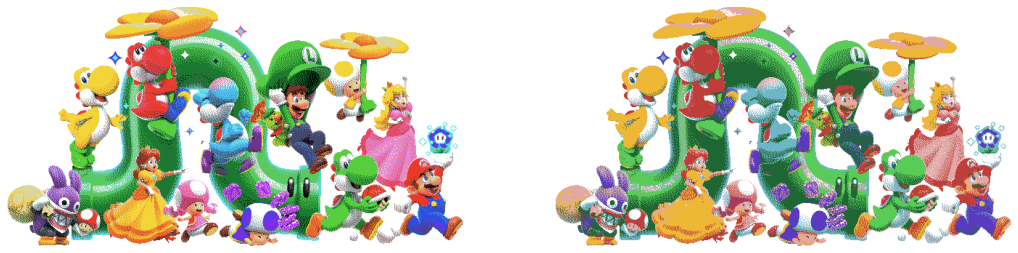

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(18, 20))
axes[0].imshow(img.input_pil)
axes[0].axis('off')  
axes[1].imshow(img.output_pil)
axes[1].axis('off')  
plt.show()